In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [144]:
plt.style.use('ggplot')
%matplotlib inline

In [145]:
df = pd.read_csv('famcs_students.csv')

In [146]:
N = 10
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[N % 8]
print(f"Вариант N={N}, Целевая переменная: {target_col}")

Вариант N=10, Целевая переменная: weekend_study


In [147]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

In [148]:
selected_features = ['score', 'miss', 'work_experience', 'bad_sleep', 'interest']

In [149]:
data = df[selected_features + [target_col]].copy()

In [150]:
data[target_col] = data[target_col].map({'Да': 1, 'Нет': 0})
data['bad_sleep'] = data['bad_sleep'].map({'Да': 1, 'Нет': 0})

In [151]:
work_map = {
    'Не работаю': 0,
    'Меньше года': 1,
    '1-2 года': 2,
    '2-3 года': 3,
    'Более 3 лет': 4,
    'более 2 лет': 3 
}
data['work_experience'] = data['work_experience'].map(work_map).fillna(0)

In [152]:
data['interest'] = data['interest'].map({'Математика': 0, 'Программирование': 1})

In [153]:
data = data.dropna()

In [154]:
print(f"Используемые признаки: {selected_features}")
print(f"Размер датасета после обработки: {data.shape}")
data.head()

Используемые признаки: ['score', 'miss', 'work_experience', 'bad_sleep', 'interest']
Размер датасета после обработки: (127, 6)


,score,miss,work_experience,bad_sleep,interest,weekend_study
0,9.2,3.0,1,1,0,1
1,8.8,5.0,2,0,1,0
2,8.8,10.0,1,0,1,1
3,8.8,3.0,2,1,0,1
4,9.0,1.0,0,0,0,1


In [155]:
X = data[selected_features].values
y = data[target_col].values

In [156]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [157]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [158]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-9 

In [159]:
X_train_scaled = (X_train - mean) / std
X_val_scaled = (X_val - mean) / std
X_test_scaled = (X_test - mean) / std

In [160]:
print(f"Размеры выборок: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")

Размеры выборок: Train (88, 5), Val (19, 5), Test (20, 5)


In [161]:
class MajorityClassifier:
    def fit(self, X, y):
        self.majority_class = np.bincount(y.astype(int)).argmax()
    def predict(self, X):
        return np.full(X.shape[0], self.majority_class)
    def predict_proba(self, X):
        return np.zeros(X.shape[0])

In [162]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.params = {}
        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9,
                'prior': len(X_c) / len(X)
            }
    
    def _pdf(self, class_idx, x):
        mean = self.params[class_idx]['mean']
        var = self.params[class_idx]['var']
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                posterior = np.sum(np.log(self._pdf(c, x))) + prior
                posteriors.append(posterior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

    def predict_proba(self, X):
        probs = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                posterior = np.sum(np.log(self._pdf(c, x))) + prior
                posteriors.append(posterior)
            posteriors = np.array(posteriors)
            exp_post = np.exp(posteriors - np.max(posteriors))
            probs.append(exp_post[1] / np.sum(exp_post)) 
        return np.array(probs)

In [163]:
class KNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            counts = np.bincount(k_nearest_labels.astype(int), minlength=2)
            y_pred.append(counts.argmax())
        return np.array(y_pred)
    
    def predict_proba(self, X):
        probs = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            probs.append(np.mean(k_nearest_labels == 1))
        return np.array(probs)

In [164]:
class LogisticRegressionMine:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.threshold = 0.5
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X):
        y_probs = self.predict_proba(X)
        return [1 if p > self.threshold else 0 for p in y_probs]

In [165]:
trivial = MajorityClassifier()
trivial.fit(X_train_scaled, y_train)

In [166]:
nb = NaiveBayes()
nb.fit(X_train_scaled, y_train)

In [167]:
best_k = 1
best_acc = 0

for k in range(1, 21):
    knn = KNN(k=k)
    knn.fit(X_train_scaled, y_train)
    val_pred = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, val_pred)
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Оптимальный k для KNN: {best_k}")

Оптимальный k для KNN: 9


In [168]:
lr = LogisticRegressionMine(learning_rate=0.1, epochs=3000)
lr.fit(X_train_scaled, y_train)
val_probs_lr = lr.predict_proba(X_val_scaled)

thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = [1 if p > t else 0 for p in val_probs_lr]
    f1_scores.append(f1_score(y_val, preds, zero_division=0))
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds, zero_division=0))

best_threshold = thresholds[np.argmax(f1_scores)]
lr.threshold = best_threshold 

print(f"Оптимальный порог для LogReg: {best_threshold:.2f}")

Оптимальный порог для LogReg: 0.01


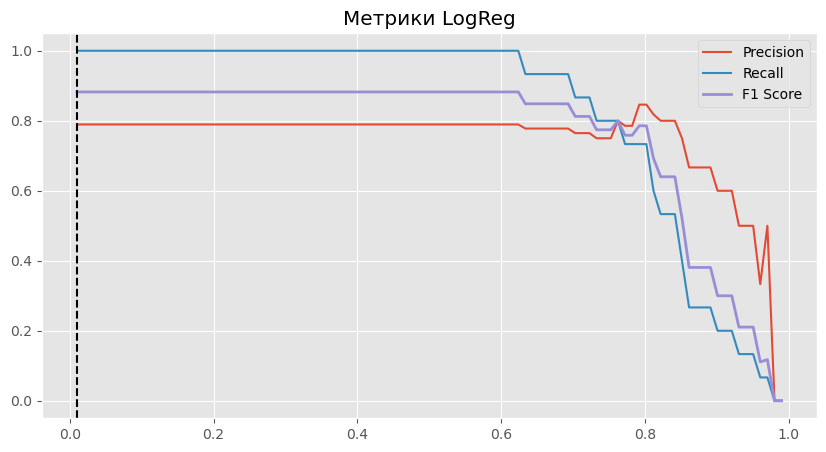

In [169]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.axvline(best_threshold, color='black', linestyle='--')
plt.title('Метрики LogReg')
plt.legend()
plt.show()

=== Trivial ===
Accuracy:  0.7500
Precision: 0.7500
Recall:    1.0000
ROC-AUC:   0.5000


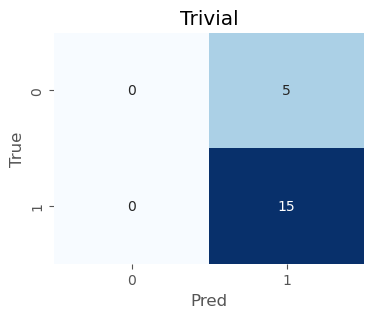



=== Naive Bayes ===
Accuracy:  0.8000
Precision: 0.7895
Recall:    1.0000
ROC-AUC:   0.6267


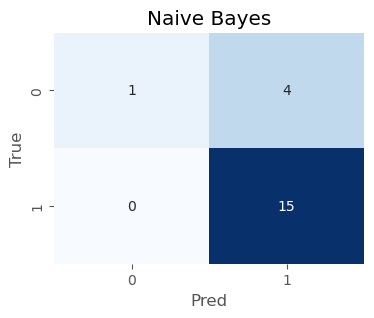



=== KNN (k=9) ===
Accuracy:  0.7500
Precision: 0.7500
Recall:    1.0000
ROC-AUC:   0.6267


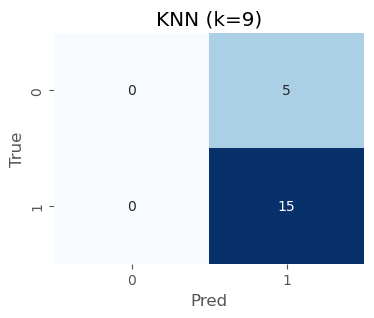



=== Logistic Regression ===
Accuracy:  0.7500
Precision: 0.7500
Recall:    1.0000
ROC-AUC:   0.6667


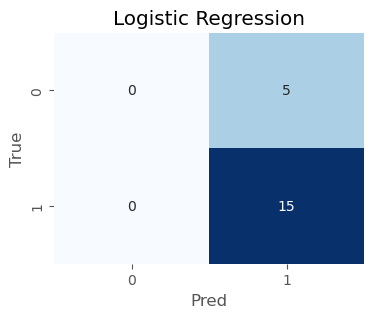

In [170]:
knn_best = KNN(k=best_k)
knn_best.fit(X_train_scaled, y_train)

models = {
    'Trivial': trivial,
    'Naive Bayes': nb,
    f'KNN (k={best_k})': knn_best,
    'Logistic Regression': lr
}

for name, model in models.items():
    print(f"=== {name} ===")
    y_pred = model.predict(X_test_scaled)
    try:
        y_prob = model.predict_proba(X_test_scaled)
    except:
        y_prob = np.zeros(len(y_pred))

    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred, zero_division=0):.4f}")
    try:
        print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")
    except ValueError:
        print("ROC-AUC:   Не определен")
        
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(name)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.show()
    print("\n")